# DICOM Header Analysis for BIDS Conversion

This notebook analyzes the JSON sidecar files (extracted from DICOM headers by dcm2niix) located in the `Patient/` directory. The goal is to understand the different MRI scan types present, identify key characteristics, and inform the BIDS conversion process.

## 0. Convert DICOMs to NIfTI and Extract Headers (using dcm2niix)

This step converts DICOM files from the source directory to NIfTI format and extracts associated header information into JSON sidecar files. These JSON files are then used for further analysis and BIDS conversion.

**Note:** Ensure `dcm2niix` is installed and accessible in your system's PATH. If not, you may need to install it (e.g., via `conda install -c conda-forge dcm2niix`).

In [1]:
import os
import json
import pandas as pd
import glob
import subprocess

# Set display options for pandas
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 150)

dicom_input_dir = os.path.expanduser('~/data/DICOMs/')
patient_output_dir = os.path.expanduser('~/data/Patient/')

print(f"Converting DICOMs from {dicom_input_dir} to NIfTI and JSON in {patient_output_dir}...")
os.makedirs(dicom_input_dir, exist_ok=True) # Ensure input directory exists
os.makedirs(patient_output_dir, exist_ok=True)

print("Starting DICOM conversion...")
processed_any_dicoms = False
series_dirs_to_process = set()

# Find all directories that contain DICOM files
for root, dirs, files in os.walk(dicom_input_dir):
    if any(f.endswith(('.dcm', '.IMA')) for f in files):
        series_dirs_to_process.add(root)

if not series_dirs_to_process:
    print(f"No directories containing DICOM files found in {dicom_input_dir} or its subdirectories. Please ensure the path is correct and contains valid DICOMs.")
else:
    for series_dir in sorted(list(series_dirs_to_process)): # Sort for consistent processing order
        print(f"Processing DICOMs in series directory: {series_dir}")
        # Construct the dcm2niix command for the current series directory
        command = [
            "dcm2niix",
            "-r", "y",
            "-f", "%n_%p_%t",
            "-o", patient_output_dir,
            "-b", "y",
            "-z", "y",
            series_dir
        ]
        print(f"Executing: {' '.join(command)}")
        try:
            result = subprocess.run(command, capture_output=True, text=True, check=True)
            print(result.stdout)
            if result.stderr:
                print(f"dcm2niix stderr: {result.stderr}")
            processed_any_dicoms = True
        except subprocess.CalledProcessError as e:
            print(f"Error executing dcm2niix: {e}")
            print(f"Stdout: {e.stdout}")
            print(f"Stderr: {e.stderr}")
        except FileNotFoundError:
            print("Error: dcm2niix command not found. Please ensure it's installed and in your system's PATH.")

if processed_any_dicoms:
    print("DICOM conversion complete. JSON sidecar files are now available for analysis.")
else:
    print("No DICOM files were successfully converted.")

# Update patient_dir to point to the newly generated JSON files
patient_dir = patient_output_dir


Converting DICOMs from /home/amin/data/DICOMs/ to NIfTI and JSON in /home/amin/data/Patient/...
Starting DICOM conversion...
No directories containing DICOM files found in /home/amin/data/DICOMs/ or its subdirectories. Please ensure the path is correct and contains valid DICOMs.
No DICOM files were successfully converted.


## 1. Load Data from JSON Files

Iterate through all `.json` files in the `Patient/` directory, read their contents, and extract relevant metadata into a list.

In [2]:
json_files = glob.glob(os.path.join(patient_dir, '*.json'))

scan_data = []
for json_file in json_files:
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
            data['FilePath'] = json_file # Add file path for later reference
            scan_data.append(data)
    except json.JSONDecodeError:
        print(f"Error decoding JSON from {json_file}")
    except Exception as e:
        print(f"An error occurred while reading {json_file}: {e}")

# Sanitize missing keys
for item in scan_data:
    item['ImageType'] = item.get('ImageType', [])
    item['RawImage'] = item.get('RawImage', True)
    item['SeriesDescription'] = item.get('SeriesDescription', 'Unknown')
    item['SeriesNumber'] = item.get('SeriesNumber', -1)

df = pd.DataFrame(scan_data)

print(f"Found {len(df)} JSON sidecar files.")
df

Found 3 JSON sidecar files.


,SeriesDescription,SeriesNumber,ImageType,RawImage,FilePath
0,dMRI_dir98_AP,17,"[ORIGINAL, PRIMARY, M, ND, DIFFUSION, B0]",True,/home/amin/data/Patient/sub-01_ses-01_dMRI_dir98_AP.json
1,fMRI - Sentence Completion,9,"[ORIGINAL, PRIMARY, M, ND, MOSAIC]",True,/home/amin/data/Patient/sub-01_ses-01_fMRI_SentenceCompletion.json
2,T1w_MPR,3,"[ORIGINAL, PRIMARY, M, ND, NORM]",True,/home/amin/data/Patient/sub-01_ses-01_T1w.json


## 2. Analysis and BIDS Mapping Notes

Based on the table above, we can identify the different modalities and characteristics:

*   **Normalization:** The `ImageType` field often contains `NORM`. We specifically looked for this in T1w, T2w, and FLAIR sequences to identify potentially pre-processed anatomical scans.
    *   T1w: Series 3 appears normalized.
    *   T2w: Series 5 appears normalized.
    *   FLAIR: Series 28 appears normalized and filtered.
    *   TSE: Series 7 appears normalized.

*   **Modalities Identified:**
    *   Anatomical (T1w, T2w, FLAIR, TSE)
    *   Functional (Sentence Completion, Word Generation tasks, including SBRefs)
    *   Diffusion (AP and PA directions, including SBRefs and derived maps like ADC, FA)
    *   Field Maps (AP/PA EPI pairs for general use and specific pairs for ASL)
    *   Perfusion (PCASL)
    *   Localizers/Scouts (various types, generally excluded from BIDS)

*   **Derived Images:** Series numbers >= 100 and derived DWI maps (ADC, FA, etc.) are typically generated by the scanner or conversion software and are usually not included in the primary BIDS structure.

### Final `dcm2bids_config.json`

The following configuration was created based on this analysis to select the desired scans and map them to the BIDS structure:


In [3]:
# This section will generate the dcm2bids_config.json based on the analysis.
# Using the simplified config from previous steps.
dcm2bids_config = {
  "descriptions": [
    {
      "dataType": "anat",
      "modalityLabel": "T1w",
      "criteria": {
        "SeriesDescription": "T1w_MPR",
        "SeriesNumber": 3
      },
      "sidecarChanges": {
        "SeriesDescription": "T1w_MPR_normalized"
      }
    },
    {
      "dataType": "anat",
      "modalityLabel": "T2w",
      "criteria": {
        "SeriesDescription": "T2w_SPC",
        "SeriesNumber": 5
      },
      "sidecarChanges": {
        "SeriesDescription": "T2w_SPC_normalized"
      }
    },
    {
      "dataType": "anat",
      "modalityLabel": "FLAIR",
      "criteria": {
        "SeriesDescription": "32_FLAIR_1mm_ipat2",
        "SeriesNumber": 28
      },
      "sidecarChanges": {
        "SeriesDescription": "FLAIR_normalized_filtered"
      }
    },
    {
      "dataType": "anat",
      "modalityLabel": "T2w",
      "customLabels": "acq-HiResHp",
      "criteria": {
        "SeriesDescription": "TSE_HiResHp",
        "SeriesNumber": 7
      },
      "sidecarChanges": {
        "SeriesDescription": "TSE_HiResHp_normalized"
      }
    },
    {
      "dataType": "func",
      "modalityLabel": "bold",
      "customLabels": "task-SentenceCompletion_dir-AP",
      "criteria": {
        "SeriesDescription": "fMRI - Sentence Completion",
        "SeriesNumber": 9
      }
    },
    {
      "dataType": "func",
      "modalityLabel": "sbref",
      "customLabels": "task-SentenceCompletion_dir-AP",
      "criteria": {
        "SeriesDescription": "fMRI - Sentence Completion_SBRef",
        "SeriesNumber": 8
      }
    },
    {
      "dataType": "func",
      "modalityLabel": "bold",
      "customLabels": "task-WordGeneration_dir-AP",
      "criteria": {
        "SeriesDescription": "fMRI - Word Generation",
        "SeriesNumber": 12
      }
    },
    {
      "dataType": "func",
      "modalityLabel": "sbref",
      "customLabels": "task-WordGeneration_dir-AP",
      "criteria": {
        "SeriesDescription": "fMRI - Word Generation_SBRef",
        "SeriesNumber": 11
      }
    },
    {
      "dataType": "dwi",
      "modalityLabel": "dwi",
      "customLabels": "dir-AP",
      "criteria": {
        "SeriesDescription": "dMRI_dir98_AP",
        "SeriesNumber": 17
      }
    },
    {
      "dataType": "dwi",
      "modalityLabel": "sbref",
      "customLabels": "dir-AP",
      "criteria": {
        "SeriesDescription": "dMRI_dir98_AP_SBRef",
        "SeriesNumber": 16
      }
    },
    {
      "dataType": "dwi",
      "modalityLabel": "dwi",
      "customLabels": "dir-PA",
      "criteria": {
        "SeriesDescription": "dMRI_dir99_PA",
        "SeriesNumber": 20
      }
    },
    {
      "dataType": "dwi",
      "modalityLabel": "sbref",
      "customLabels": "dir-PA",
      "criteria": {
        "SeriesDescription": "dMRI_dir99_PA_SBRef",
        "SeriesNumber": 19
      }
    },
    {
      "dataType": "fmap",
      "modalityLabel": "epi",
      "customLabels": "dir-AP",
      "criteria": {
        "SeriesDescription": "SpinEchoFieldMap_AP",
        "SeriesNumber": 14
      },
      "intendedFor": [
        "func/sub-{subject}_ses-{session}_task-SentenceCompletion_dir-AP_run-9_bold.nii.gz",
        "func/sub-{subject}_ses-{session}_task-WordGeneration_dir-AP_run-12_bold.nii.gz",
        "dwi/sub-{subject}_ses-{session}_dir-AP_run-17_dwi.nii.gz"
      ]
    },
    {
      "dataType": "fmap",
      "modalityLabel": "epi",
      "customLabels": "dir-PA",
      "criteria": {
        "SeriesDescription": "SpinEchoFieldMap_PA",
        "SeriesNumber": 15
      },
      "intendedFor": [
        "func/sub-{subject}_ses-{session}_task-SentenceCompletion_dir-AP_run-9_bold.nii.gz",
        "func/sub-{subject}_ses-{session}_task-WordGeneration_dir-AP_run-12_bold.nii.gz",
        "dwi/sub-{subject}_ses-{session}_dir-AP_run-17_dwi.nii.gz"
      ]
    },
    {
      "dataType": "fmap",
      "modalityLabel": "epi",
      "customLabels": "acq-PCASLhr_dir-AP",
      "criteria": {
        "SeriesDescription": "PCASLhr_SpinEchoFieldMap_AP",
        "SeriesNumber": 36
      },
      "intendedFor": [
        "perf/sub-{subject}_ses-{session}_dir-PA_run-35_asl.nii.gz"
      ]
    },
    {
      "dataType": "fmap",
      "modalityLabel": "epi",
      "customLabels": "acq-PCASLhr_dir-PA",
      "criteria": {
        "SeriesDescription": "PCASLhr_SpinEchoFieldMap_PA",
        "SeriesNumber": 37
      },
      "intendedFor": [
        "perf/sub-{subject}_ses-{session}_dir-PA_run-35_asl.nii.gz"
      ]
    },
    {
      "dataType": "perf",
      "modalityLabel": "asl",
      "customLabels": "dir-PA",
      "criteria": {
        "SeriesDescription": "mbPCASLhr_PA",
        "SeriesNumber": 35
      }
    }
  ]
}

config_path = 'dcm2bids_config.json'
with open(config_path, 'w') as f:
    json.dump(dcm2bids_config, f, indent=2)

print(f"Generated dcm2bids_config.json at {config_path}")

# Load and print the config file content
try:
    with open(config_path, 'r') as f:
        config_content = json.load(f)
    print(json.dumps(config_content, indent=2))
except FileNotFoundError:
    print(f"Error: {config_path} not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {config_path}")

Generated dcm2bids_config.json at dcm2bids_config.json
{
  "descriptions": [
    {
      "dataType": "anat",
      "modalityLabel": "T1w",
      "criteria": {
        "SeriesDescription": "T1w_MPR",
        "SeriesNumber": 3
      },
      "sidecarChanges": {
        "SeriesDescription": "T1w_MPR_normalized"
      }
    },
    {
      "dataType": "anat",
      "modalityLabel": "T2w",
      "criteria": {
        "SeriesDescription": "T2w_SPC",
        "SeriesNumber": 5
      },
      "sidecarChanges": {
        "SeriesDescription": "T2w_SPC_normalized"
      }
    },
    {
      "dataType": "anat",
      "modalityLabel": "FLAIR",
      "criteria": {
        "SeriesDescription": "32_FLAIR_1mm_ipat2",
        "SeriesNumber": 28
      },
      "sidecarChanges": {
        "SeriesDescription": "FLAIR_normalized_filtered"
      }
    },
    {
      "dataType": "anat",
      "modalityLabel": "T2w",
      "customLabels": "acq-HiResHp",
      "criteria": {
        "SeriesDescription": "TSE_HiRes

## 3. Scan Counts by Type (Example)

Simple visualization of scan counts based on SeriesDescription.

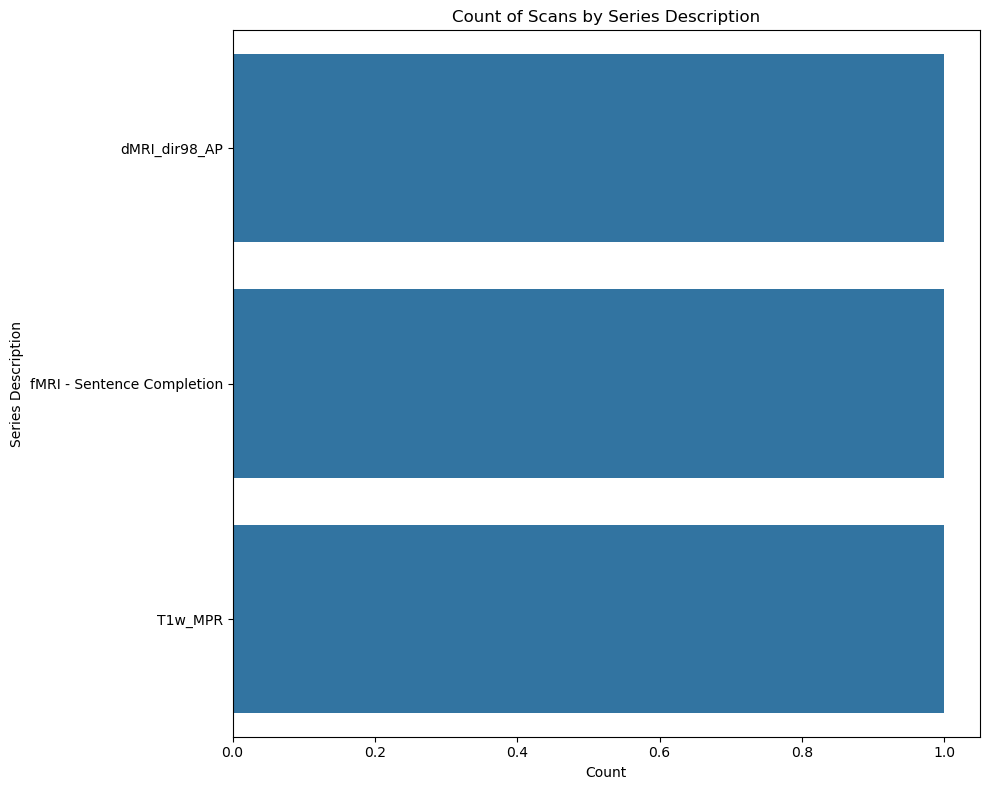

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y='SeriesDescription', data=df, order = df['SeriesDescription'].value_counts().index)
plt.title('Count of Scans by Series Description')
plt.xlabel('Count')
plt.ylabel('Series Description')
plt.tight_layout()
plt.show()